# Press Freedom Index - Gif

In [1]:
import os
import glob
import configparser

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.lines import Line2D
from matplotlib import font_manager

In [2]:
#set filepaths
project_root = os.path.abspath(os.getcwd())
root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
config_file =  os.path.join(root, "config.cfg")

# geodata for shapefiles
config = configparser.ConfigParser()
config.read(config_file)
gdata_root = config["geodata"]["path"]

## Get data

In [3]:
# load world countries shapefile
file = "ne_10m_admin_0_countries"
countries = gpd.GeoDataFrame.from_file(os.path.join(gdata_root, "natural-earth\\%s\\%s.shp" %(file, file)))
countries.head()

featurecla  scalerank  LABELRANK SOVEREIGNT SOV_A3  ADM0_DIF  LEVEL  \
0  Admin-0 country          0          2  Indonesia    IDN         0      2   
1  Admin-0 country          0          3   Malaysia    MYS         0      2   
2  Admin-0 country          0          2      Chile    CHL         0      2   
3  Admin-0 country          0          3    Bolivia    BOL         0      2   
4  Admin-0 country          0          2       Peru    PER         0      2   

                TYPE TLC      ADMIN  ... FCLASS_TR  FCLASS_ID FCLASS_PL  \
0  Sovereign country   1  Indonesia  ...      None       None      None   
1  Sovereign country   1   Malaysia  ...      None       None      None   
2  Sovereign country   1      Chile  ...      None       None      None   
3  Sovereign country   1    Bolivia  ...      None       None      None   
4  Sovereign country   1       Peru  ...      None       None      None   

  FCLASS_GR  FCLASS_IT FCLASS_NL FCLASS_SE  FCLASS_BD FCLASS_UA  \
0      None       None      None      None       None      None   
1      None       None      None      None       None      None   
2      None       None      None      None       None      None   
3      None       None      None      None       None      None   
4      None       None      None      None       None      None   

                                            geometry  
0  MULTIPOLYGON (((117.70361 4.16341, 117.70361 4...  
1  MULTIPOLYGON (((117.70361 4.16341, 117.69711 4...  
2  MULTIPOLYGON (((-69.51009 -17.50659, -69.50611...  
3  POLYGON ((-69.51009 -17.50659, -69.51009 -17.5...  
4  MULTIPOLYGON (((-69.51009 -17.50659, -69.63832...  

[5 rows x 169 columns]

In [130]:
#get Press Freedom Index data

#read in all years and combine
files = glob.glob(os.path.join(project_root, "PressFreedomIndex") + "/*.csv")

raw = []

for filename in files:
    df = pd.read_csv(filename, sep=';', decimal=",")
    raw.append(df)

data = pd.concat(raw, axis=0, ignore_index=True)

data.head()

Year (N)  ISO  Rank N  Score N  Score N without the exactions  \
0     2003  FIN     1.0      0.5                            NaN   
1     2003  ISL     1.0      0.5                            NaN   
2     2003  NOR     1.0      0.5                            NaN   
3     2003  NLD     1.0      0.5                            NaN   
4     2003  DNK     5.0      1.0                            NaN   

   Score N with the exactions  Score exactions  Rank N-1  Score N-1  \
0                         NaN              NaN       1.0        0.5   
1                         NaN              NaN       2.0        0.5   
2                         NaN              NaN       3.0        0.5   
3                         NaN              NaN       4.0        0.5   
4                         NaN              NaN      10.0        3.0   

   Rank evolution  ... Social Context Rank_Soc Safety Rank_Saf Country_EN  \
0             0.0  ...            NaN      NaN    NaN      NaN        NaN   
1             1.0  ...            NaN      NaN    NaN      NaN        NaN   
2             2.0  ...            NaN      NaN    NaN      NaN        NaN   
3             3.0  ...            NaN      NaN    NaN      NaN        NaN   
4             5.0  ...            NaN      NaN    NaN      NaN        NaN   

  Country_FR  Country_ES  Country_AR  Country_FA  Rank evolution,,,,,,  
0        NaN         NaN         NaN         NaN                   NaN  
1        NaN         NaN         NaN         NaN                   NaN  
2        NaN         NaN         NaN         NaN                   NaN  
3        NaN         NaN         NaN         NaN                   NaN  
4        NaN         NaN         NaN         NaN                   NaN  

[5 rows x 32 columns]

[85 ; 100 points] : Good situation (green)

[75 ; 85 points] : Satisfactory situation (yellow)

[65 ; 75 points] : Problematic situation (light orange)

[45 ; 65 points] : Difficult situation (dark orange)

[0 ; 45 points] : Very serious situation (dark red)


In [131]:
## clean country names
data["ISO_clean"] = data["ISO"]
data["ISO_clean"] = data["ISO_clean"].str.replace("USA2", "USA")

# score classification
classification = []

for score in data["Score N"]:
    if score >= 85:
        classification.append(5)
    elif (score < 85) & (score >=75):
        classification.append(4)
    elif (score < 75) & (score >=65):
        classification.append(3)
    elif (score < 65) & (score >=45):
        classification.append(2)
    elif (score < 45) & (score >=0):
        classification.append(1)
    else:
        classification.append(np.nan)

data["score_class"] = classification

score_class_labels = {5: "Good", 4: "Satisfactory", 3: "Problematic", 2: "Difficult", 1: "Very serious"}
data["score_class_labels"] = data["score_class"].map(score_class_labels)

In [134]:
data = data.dropna(subset="Year (N)")
data.loc[data["Year (N)"]=="2011-12", "Year (N)"] = 2011
data["Year (N)"] = data["Year (N)"].astype(int)

## Map

In [172]:
#Adjust viridis colormap
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=-1):
    if n == -1:
        n = cmap.N
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
         'trunc({name},{a:.2f},{b:.2f})'.format(name=cmap.name, a=minval, b=maxval),
         cmap(np.linspace(minval, maxval, n)))
    return new_cmap

minColor = 0
maxColor = 0.77
new_cmap = truncate_colormap(plt.get_cmap("viridis"), minColor, maxColor)
new_cmap

In [326]:
#font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
title_font = font_manager.FontProperties(fname='C:\\WINDOWS\\Fonts\\Inter-Bold.otf')
subtitle_font = font_manager.FontProperties(fname='C:\\WINDOWS\\Fonts\\Inter-SemiBold.otf')
label_font = font_manager.FontProperties(fname='C:\\WINDOWS\\Fonts\\Inter-Medium.otf')
small_font = font_manager.FontProperties(fname='C:\\WINDOWS\\Fonts\\Inter-Thin.otf')

In [136]:
#dataframe to plot
df1 = countries[['featurecla', 'scalerank', 'LABELRANK', 'SOVEREIGNT', 'SOV_A3', 'ADM0_DIF', 'LEVEL', 'TYPE', 'ADMIN',
           'ADM0_A3',"ISO_A3", "geometry"]]
df2 = data[['Year (N)', 'ISO','ISO_clean', 'Rank N', 'Score N',"score_class","score_class_labels", 
           'Score N without the exactions',
       'Score N with the exactions', 'Score exactions', 'Rank N-1','Score N-1', 'Rank evolution', 'EN_country']]
gdf = pd.merge(df1,df2, left_on="ADM0_A3", right_on="ISO_clean", how="inner")
gdf = gdf.to_crs(900913)

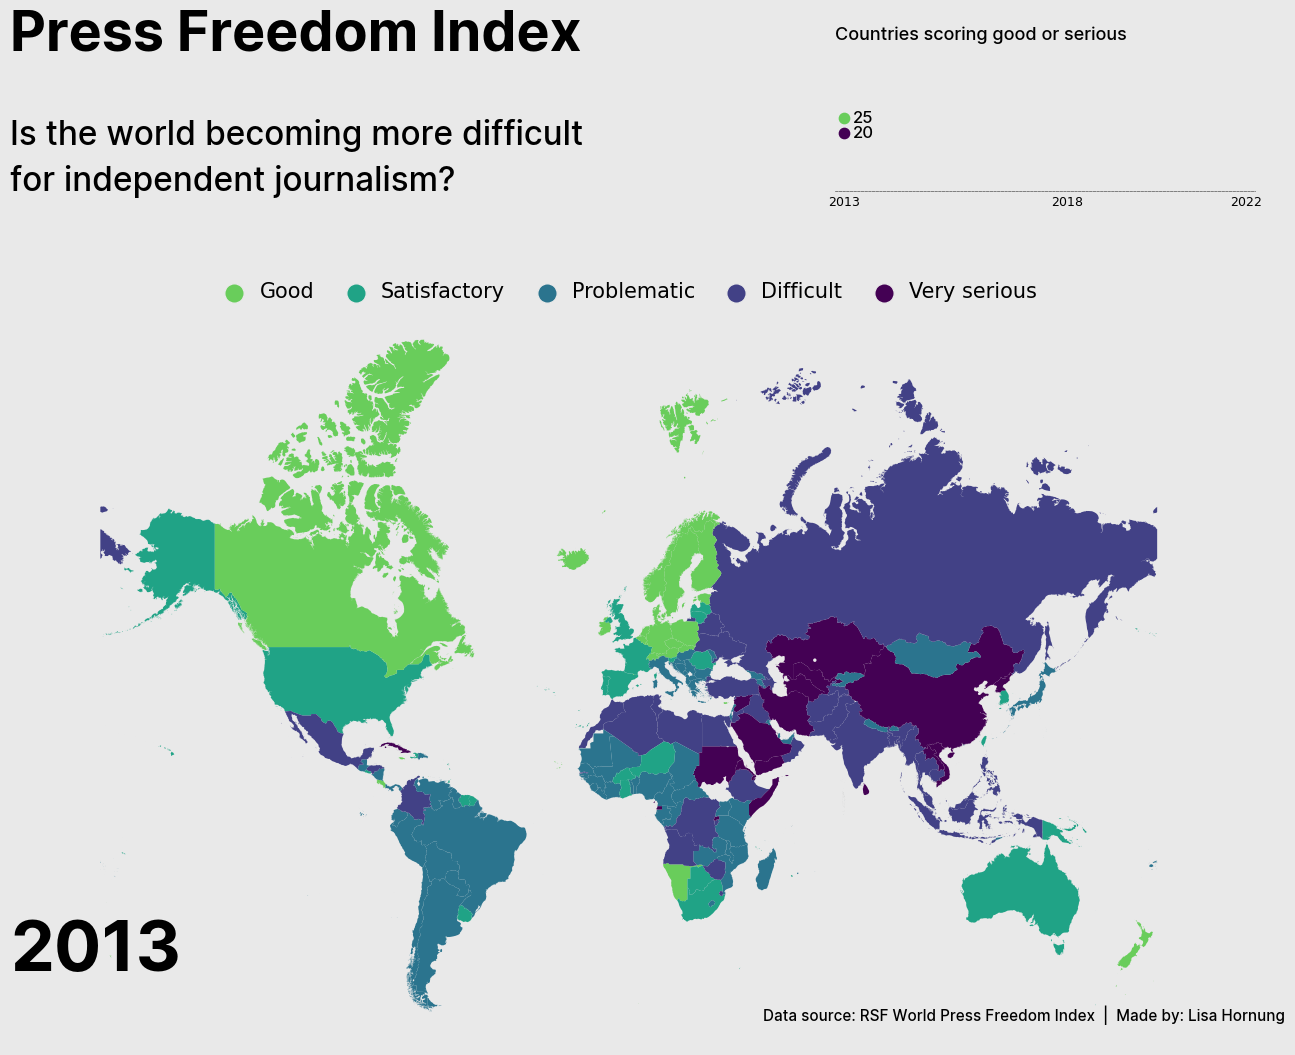

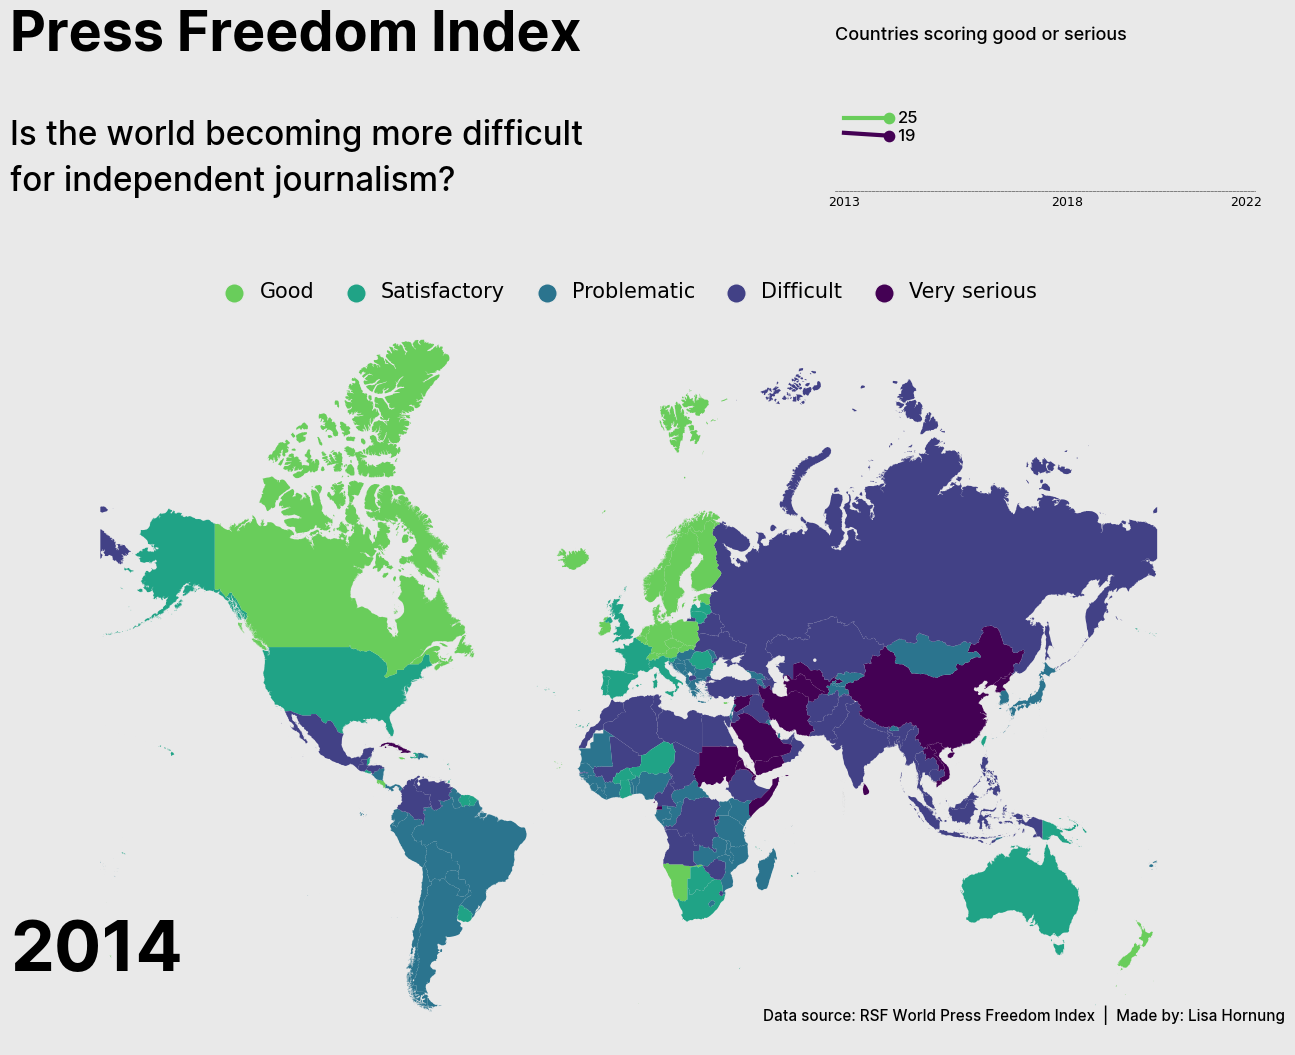

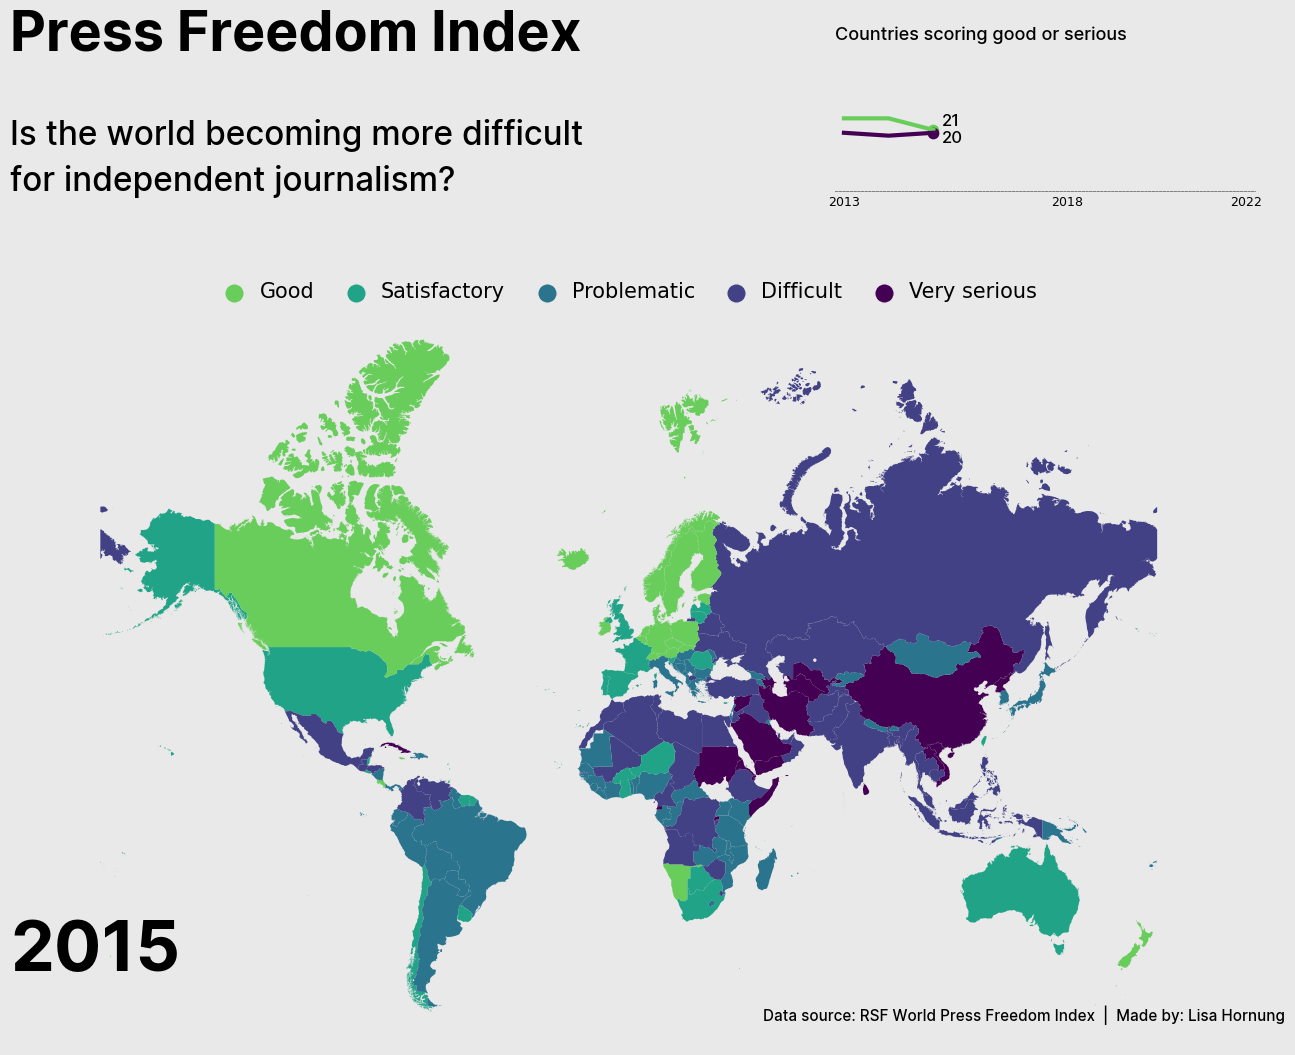

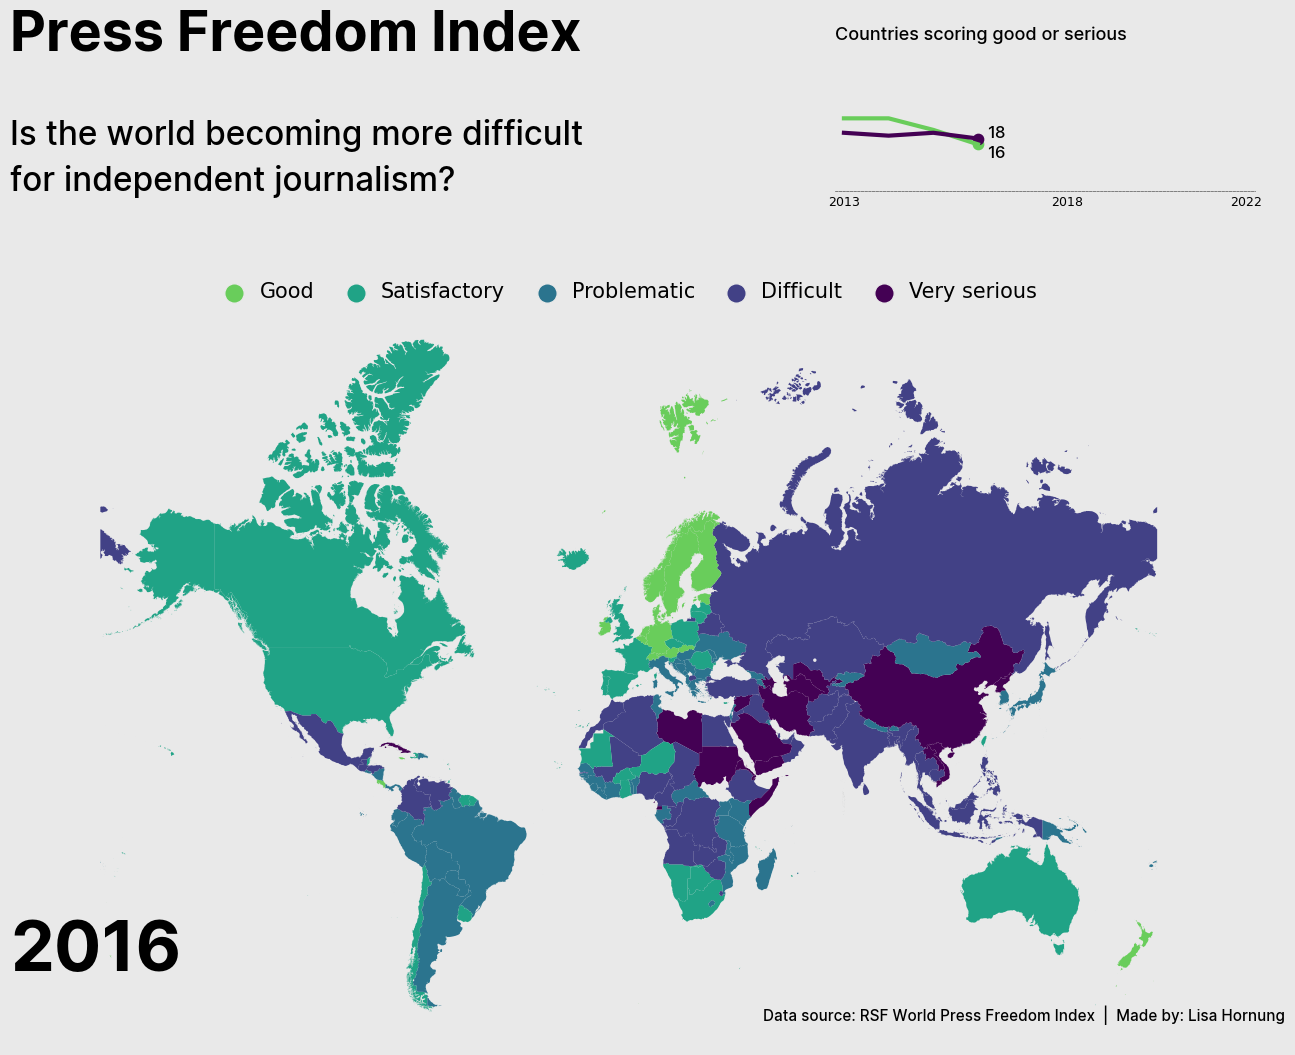

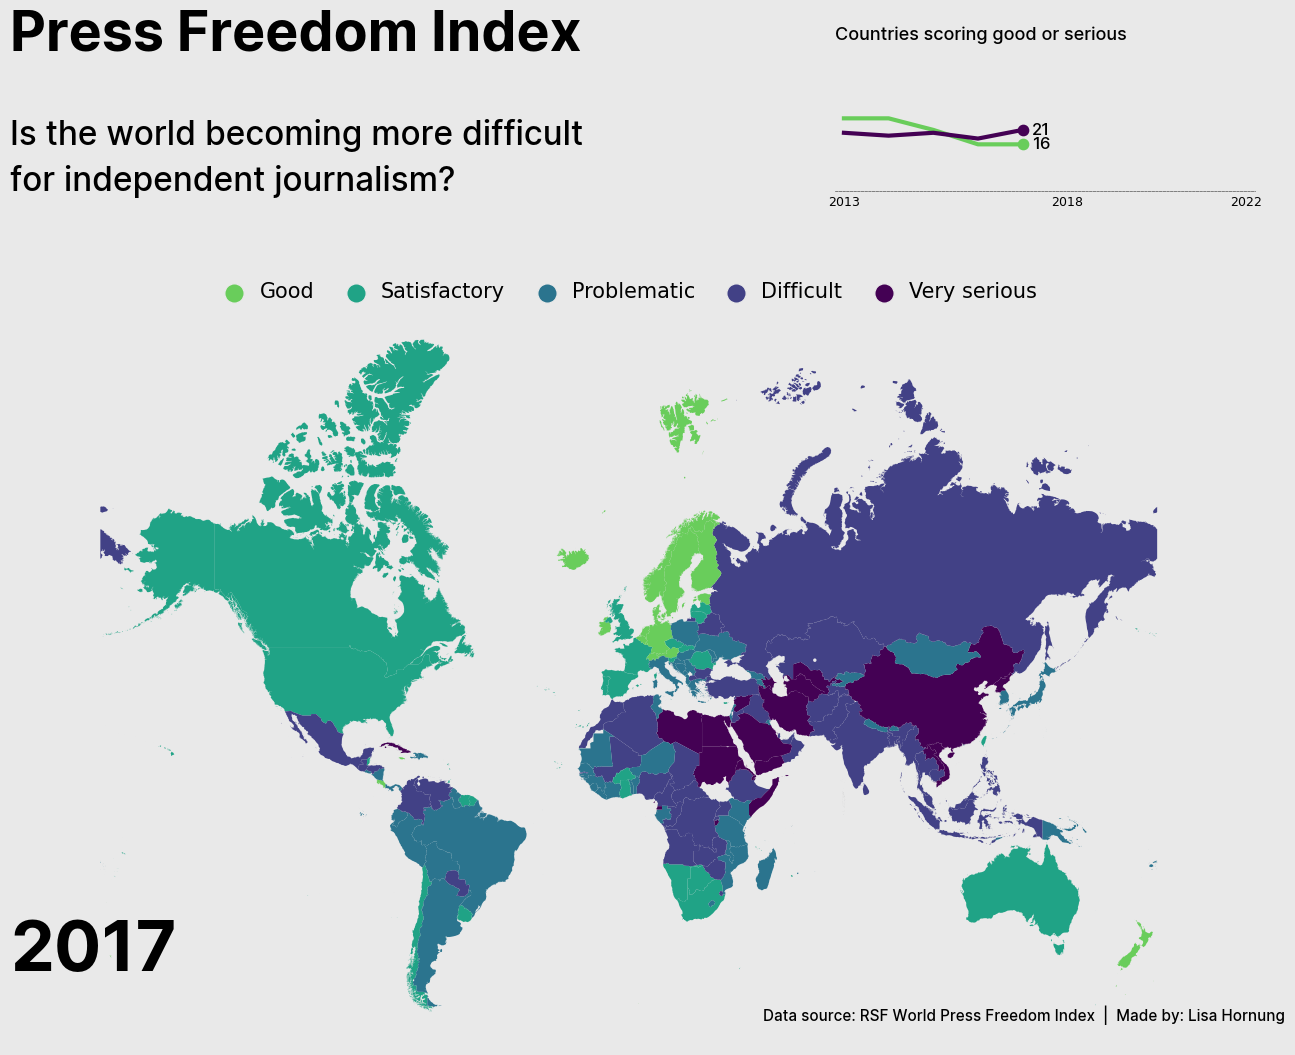

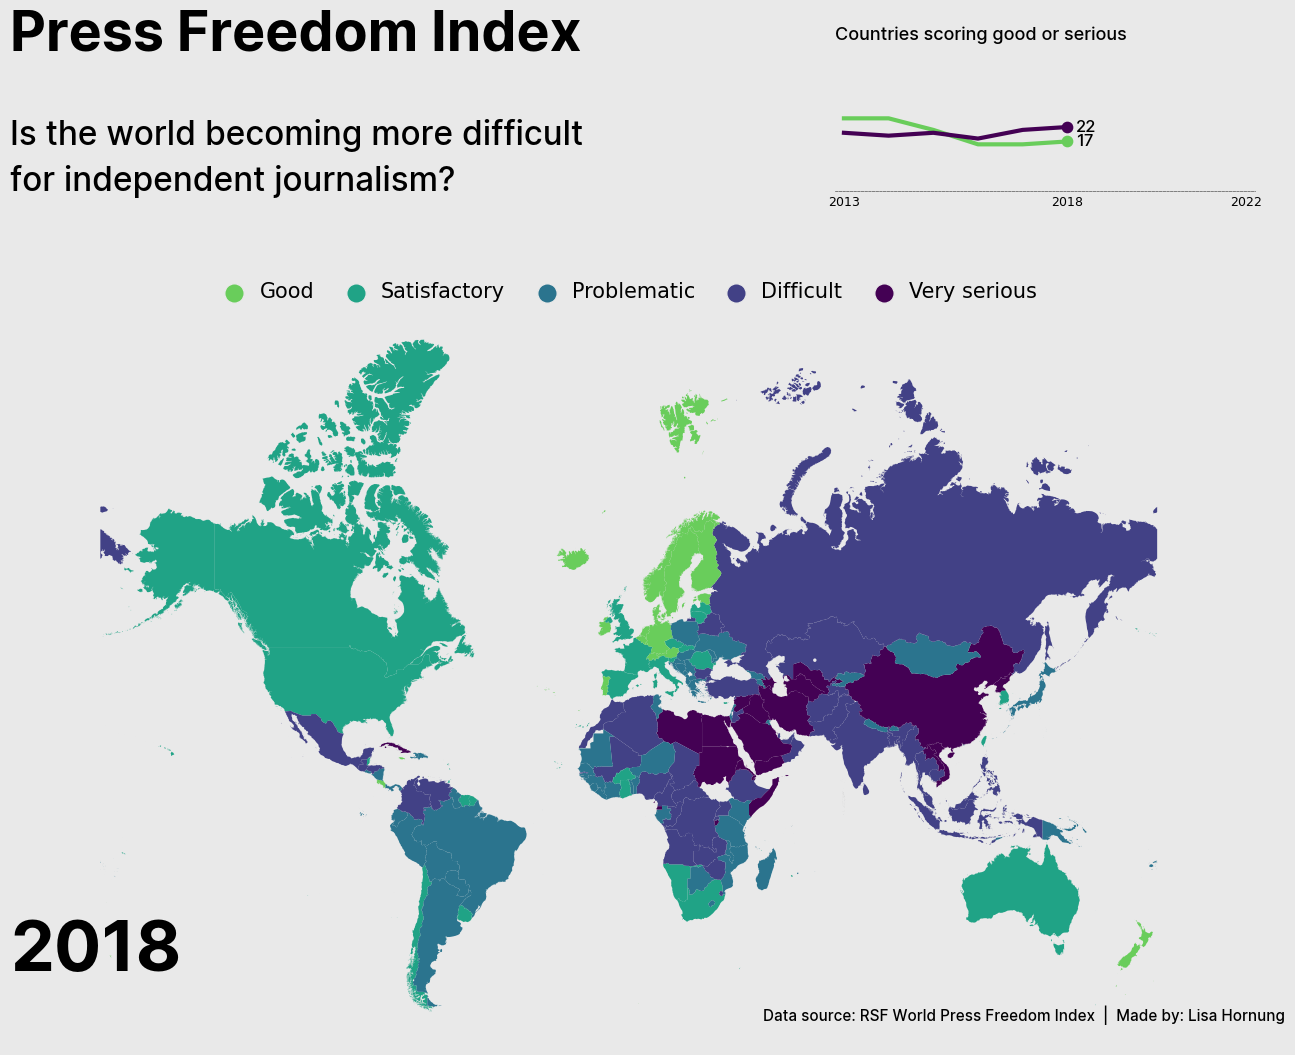

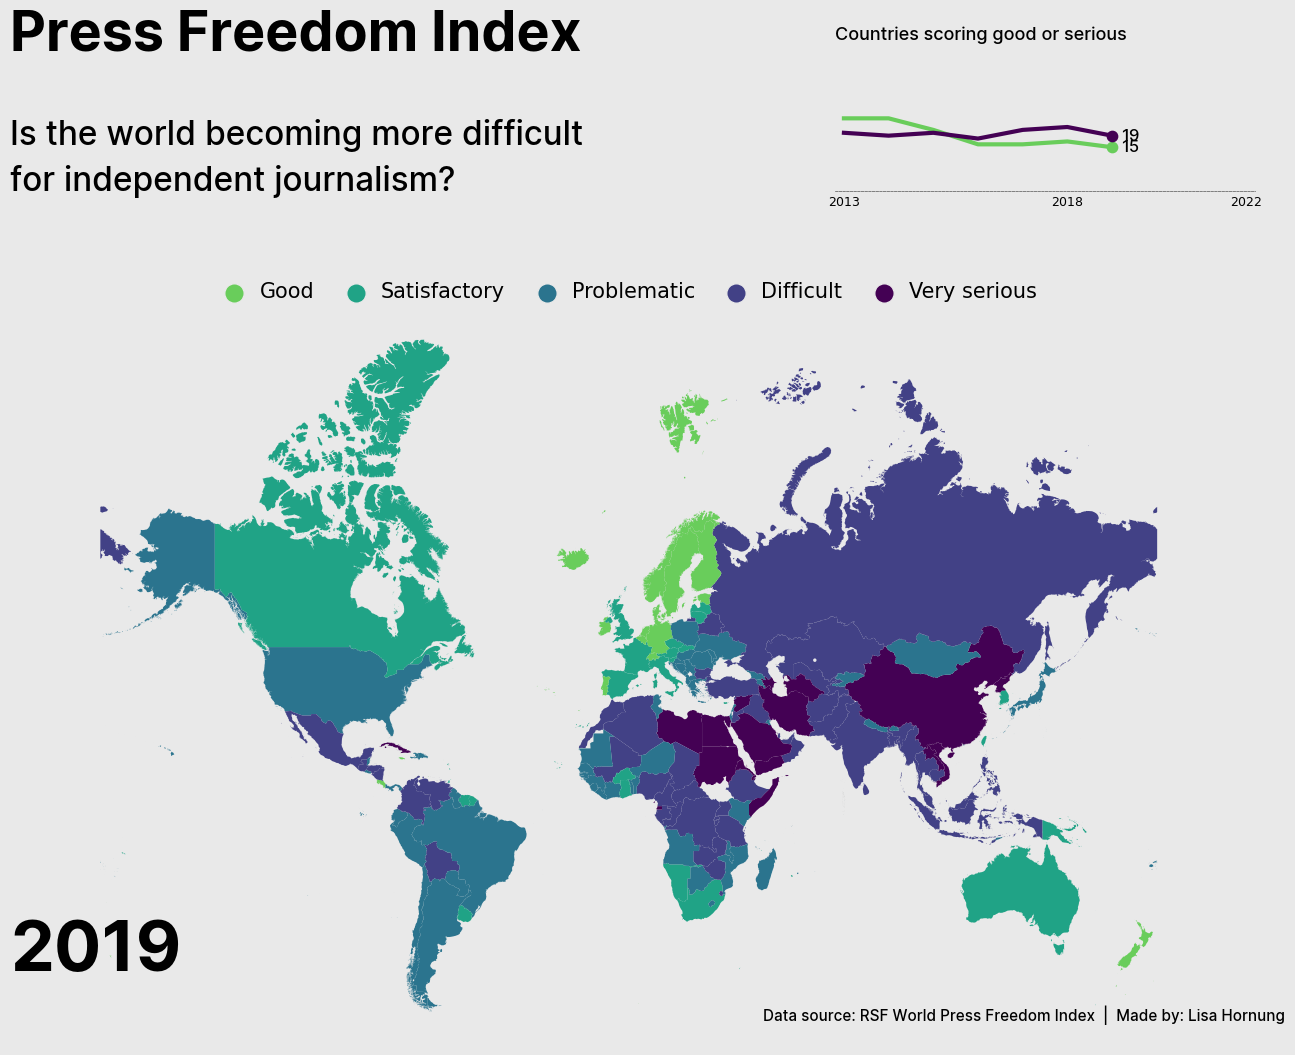

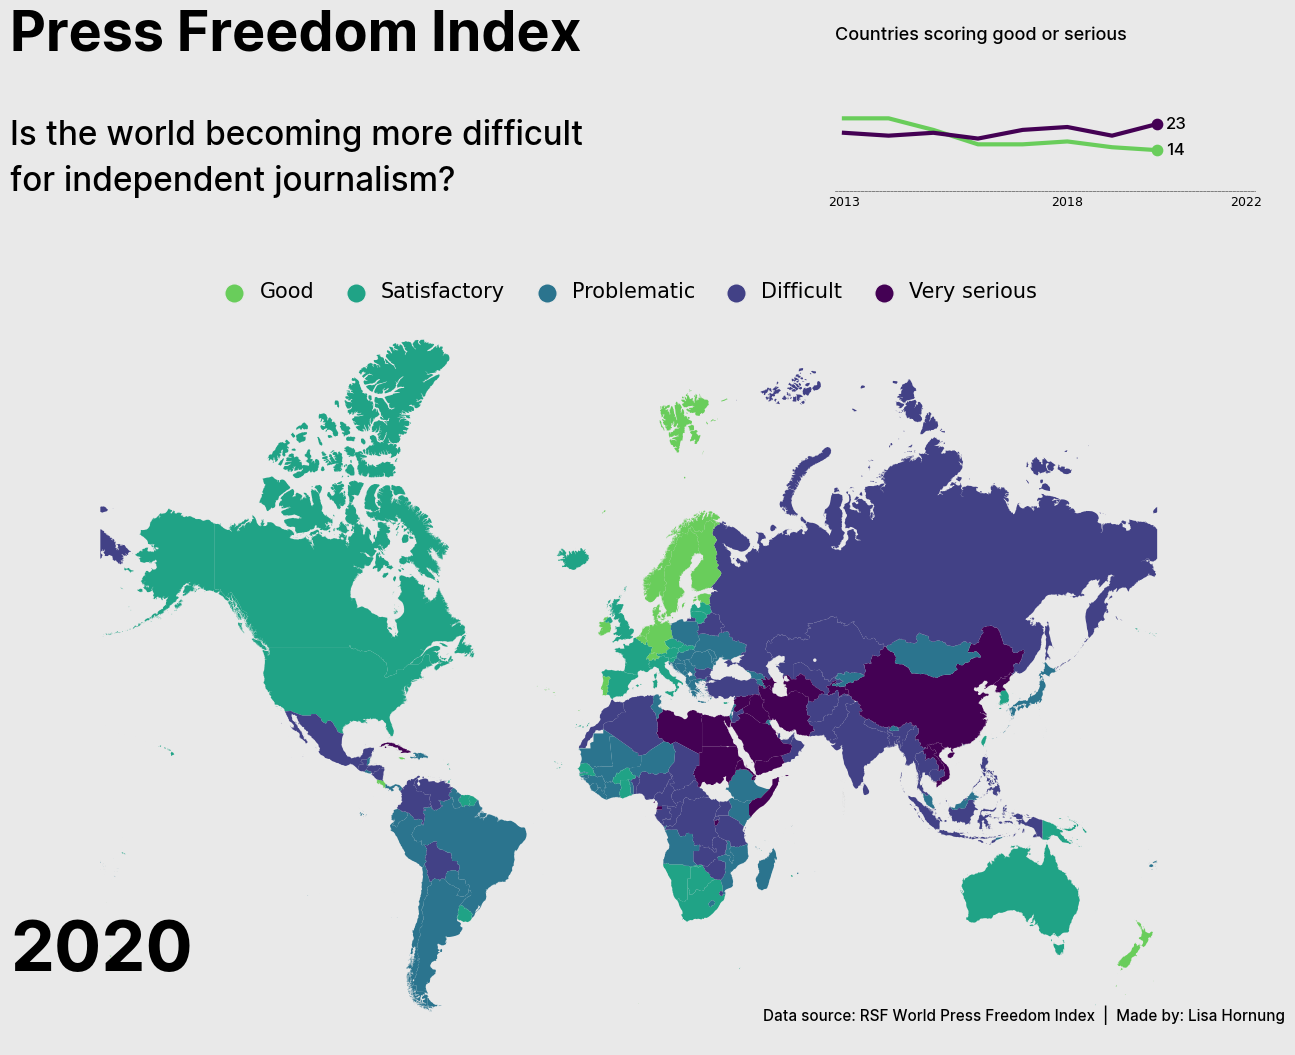

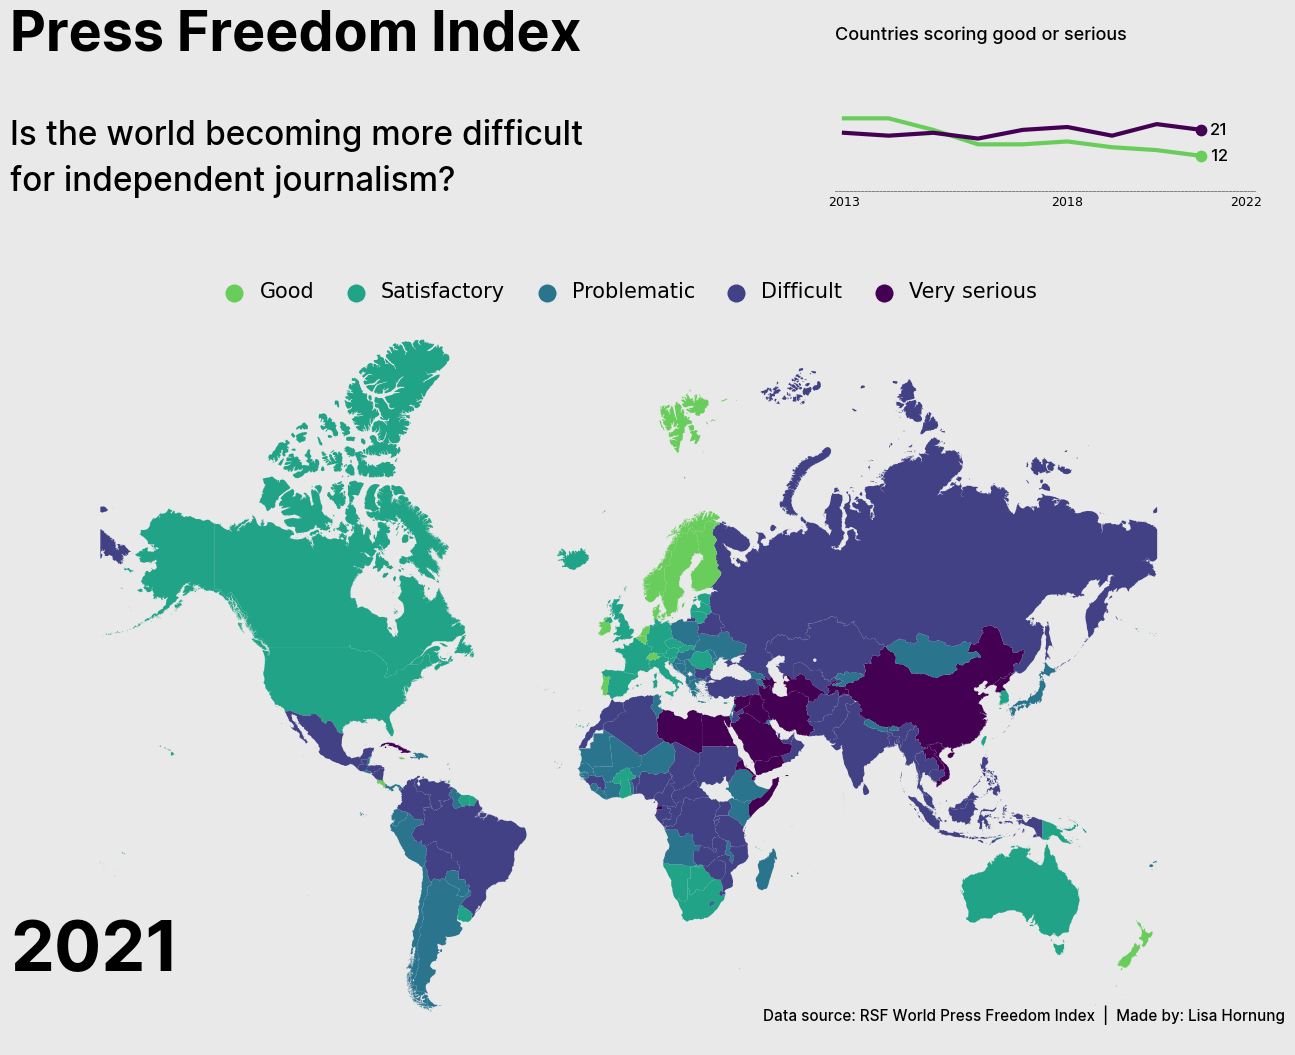

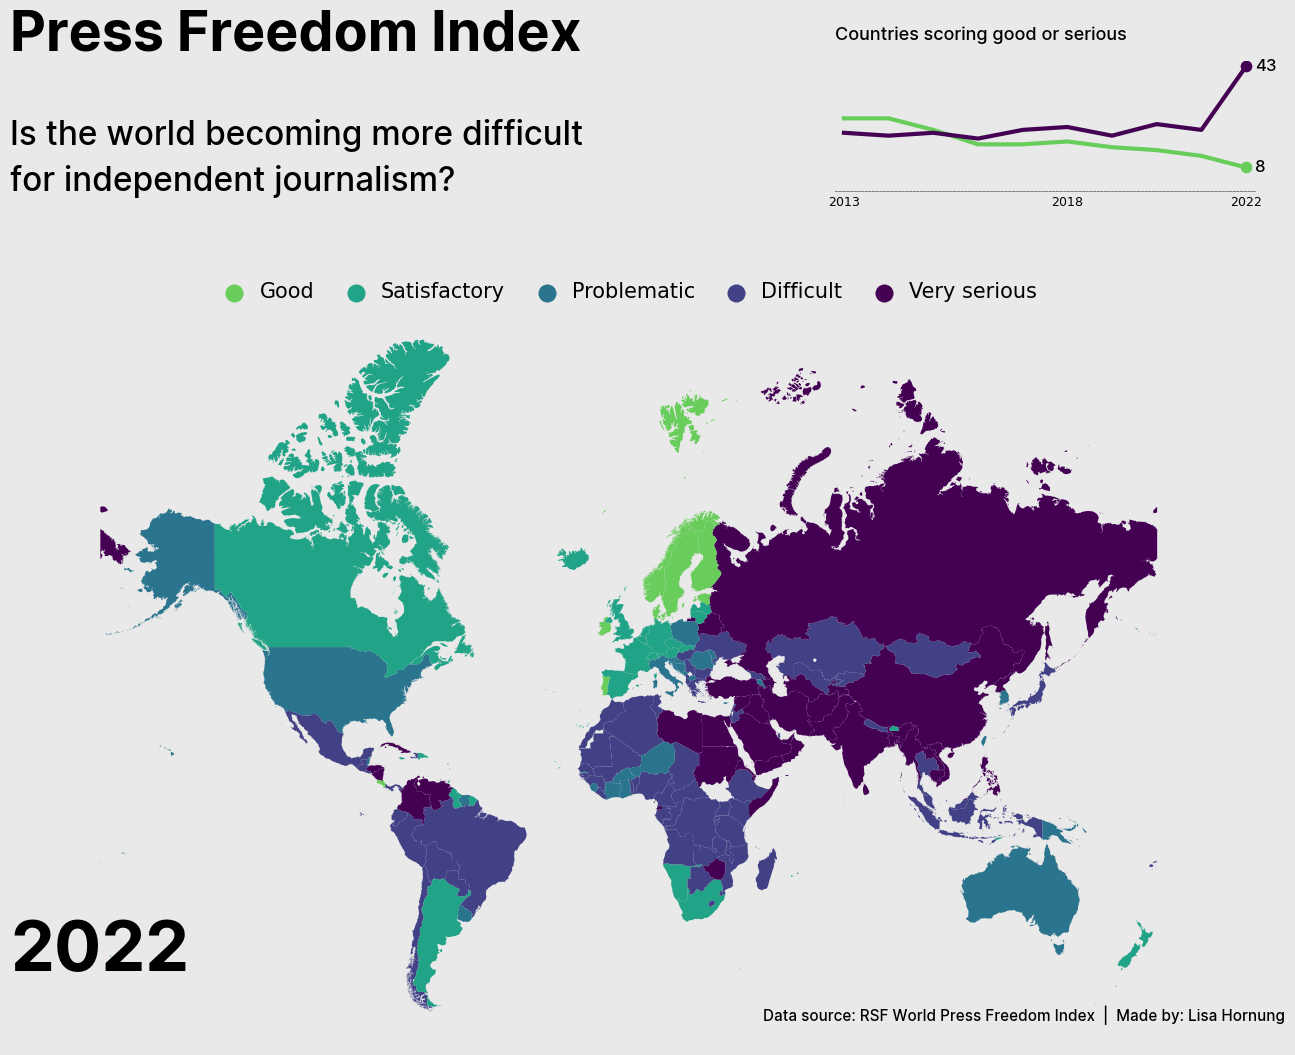

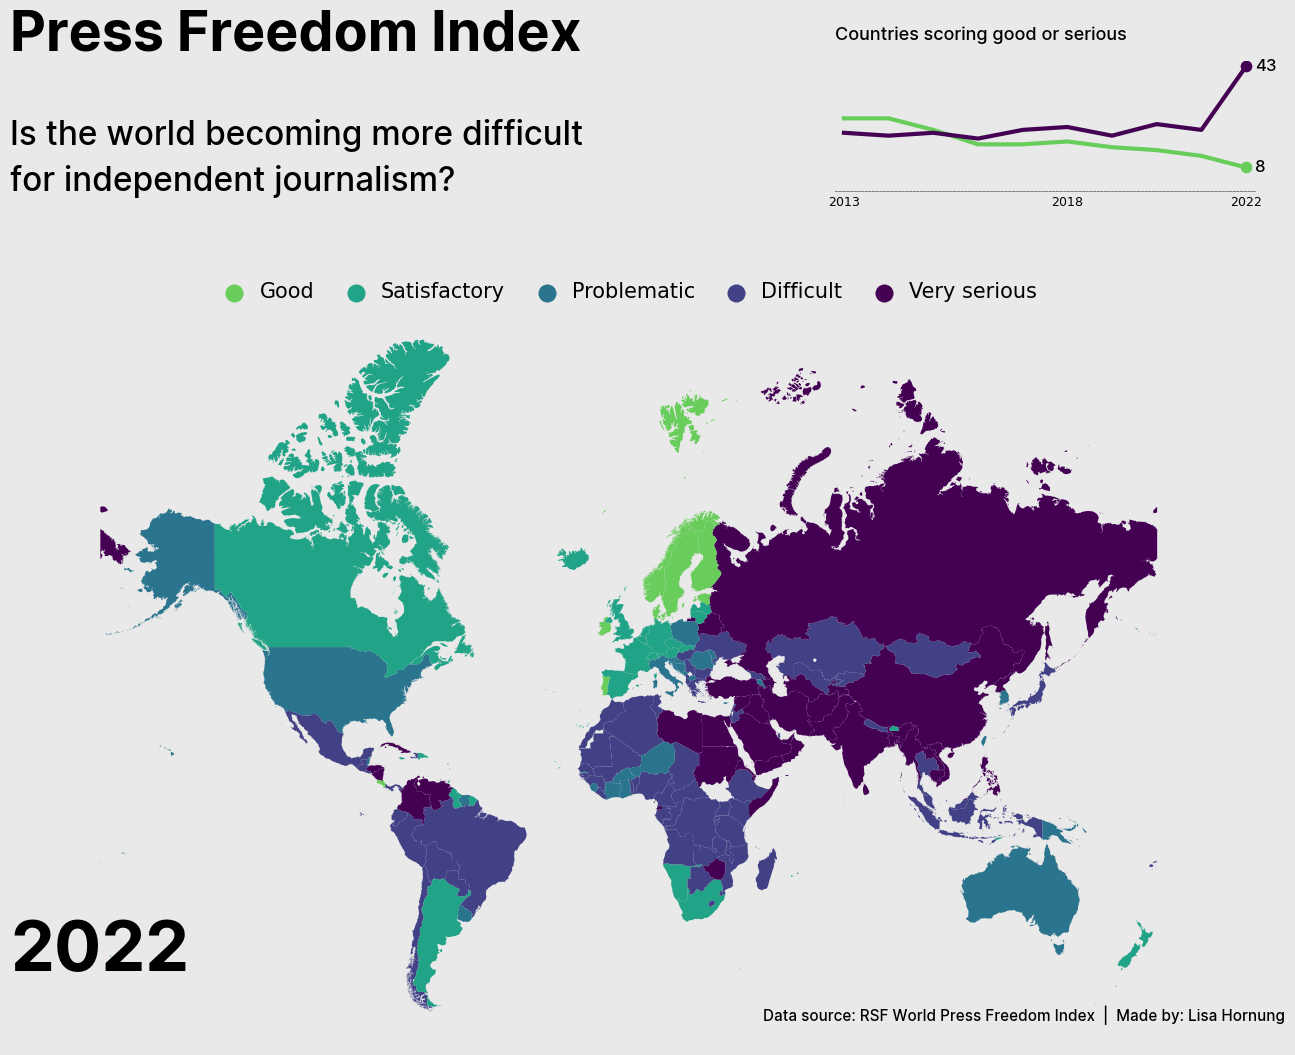

In [337]:
years = [2013,2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2022] #2022 twice for longer loop time in gif
colors = { "Good": "#69CD5B", "Satisfactory": "#20A386", "Problematic": "#2B748E", 
          "Difficult": "#424186", "Very serious": "#440154", "bg":"#E9E9E9" }

for i, year in enumerate(years):
    fig, ax = plt.subplots(figsize=(15,10))
    fig.set_facecolor(colors["bg"])
    
    #map
    gdf[gdf["Year (N)"]==year].plot(ax=ax, column="score_class", cmap=new_cmap)
    ax.axis("off")
    
    #### linechart
    ax1 = fig.add_axes([0.65,0.98,0.28,0.13], anchor='NE', zorder=1)
    ax1.set_facecolor(colors["bg"])
    _filter = (gdf["Year (N)"] >= 2013) & (gdf["Year (N)"] <= year) 
    pivot = gdf[_filter].groupby(["Year (N)", "score_class_labels"])["ISO"].count().unstack()
    pivot["Ok"] = pivot[["Good", "Satisfactory"]].sum(axis=1)
    pivot["Bad"] = pivot[["Difficult", "Very serious"]].sum(axis=1)
    
    for column in ["Good", "Very serious"]:
        ax1.plot(pivot.index, pivot[column], color=colors[column], linewidth=3)
        ax1.scatter(pivot.index[-1], pivot[column].iloc[-1], s=55,color=colors[column] )
        xpos = 0.2
        ypos = 0      
        if (year == 2015) & (column == "Good"):
            ypos = +3
        if (year == 2015) & (column == "Very serious"):
            ypos = -2
        if (year == 2016) & (column == "Good"):
            ypos = -3
        if (year == 2016) & (column == "Very serious"):
            ypos = +2           
        ax1.text(pivot.index[-1]+xpos, pivot[column].iloc[-1]+ypos, pivot[column].iloc[-1], va="center", 
                 fontproperties=label_font, fontsize=12,color="black")

    ax1.set_ylim(ymin=0, ymax=45)
    ax1.yaxis.set_visible(False)
    ax1.set_xlim(xmin=2013-0.2, xmax=2022+0.2)
    for pos in ["top", "right", "left"]:
        ax1.spines[pos].set_visible(False)   
    ax1.spines["bottom"].set(color="#555555", linewidth=0.5, linestyle="dashed")
    
    ax1.tick_params(size=0, labelsize=9)
    ax1.set_xticks([2013,2018,2022])
    ax1.set_title("Countries scoring good or serious", fontproperties=label_font,fontsize=13, x=0, y=1.1, ha="left")
    
    ## Legend
    kw = dict(marker='o', color=bg ,markersize=14 )
    legend_elements = [Line2D([0], [0], markerfacecolor=colors["Good"], **kw), 
                      Line2D([0], [0], markerfacecolor=colors["Satisfactory"],  **kw),
                      Line2D([0], [0], markerfacecolor=colors["Problematic"],**kw),
                      Line2D([0], [0], markerfacecolor=colors["Difficult"], **kw),
                      Line2D([0], [0], markerfacecolor=colors["Very serious"], **kw),]
    L = ax.legend(frameon=False, handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.05),ncol=5,
                 labels=["Good", "Satisfactory", "Problematic", "Difficult", "Very serious"])
    plt.setp(L.texts, family="Inter", size=15)
    
    ## Title and footer
    plt.figtext(0.1, 0.2, year, fontproperties= title_font,fontsize=50 )
    plt.figtext(0.1, 1.12, "Press Freedom Index", fontproperties= title_font, fontsize=40)
    plt.figtext(0.1, 0.98, "Is the world becoming more difficult\nfor independent journalism?",
                linespacing=1.5,fontproperties=label_font, fontsize=24)
    plt.figtext(0.95, 0.15, "Data source: RSF World Press Freedom Index  |  Made by: Lisa Hornung", 
                fontproperties=label_font, fontsize=11, ha="right")
    
    plt.savefig("map_%s%d.png" %(year, i), bbox_inches='tight', transparent=False, pad_inches=0.3, facecolor=bg)
    
    plt.show()

## Gif

In [339]:
## create gif
from PIL import Image
import glob

# Create the frames
frames = []
imgs = glob.glob("*.png")
for i in imgs:
    newframe=Image.open(i)
    frames.append(newframe)
    
#Save into a GIF file that loops forever
frames[0].save('press-freedom-index.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=900, loop=0)

#Save into a GIF file that loops 3 times forever
frames[0].save('press-freedom-index-3loops.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=900, loop=3)

# Code snippets

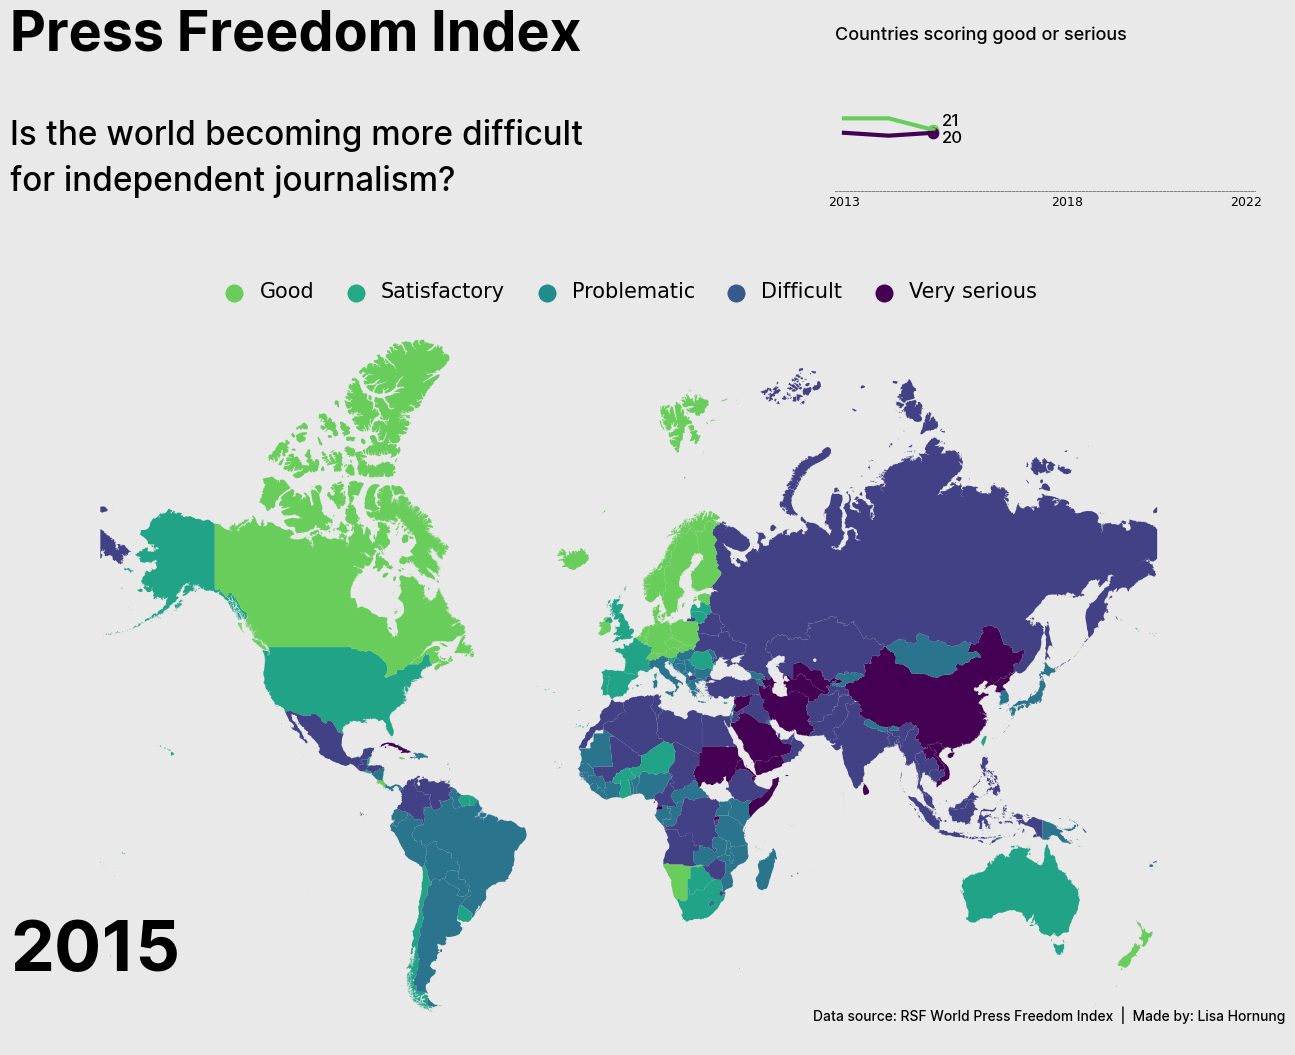

In [329]:
year = 2015

#style single map/image
fig, ax = plt.subplots(figsize=(15,10))
bg = "#E9E9E9"
fig.set_facecolor(bg)

#map
gdf[gdf["Year (N)"]==year].plot(ax=ax, column="score_class", cmap=new_cmap)
ax.axis("off")

#### linechart
ax1 = fig.add_axes([0.65,0.98,0.28,0.13], anchor='NE', zorder=1)
ax1.set_facecolor(bg)

_filter = (gdf["Year (N)"] >= 2013) & (gdf["Year (N)"] <= year) 
pivot = gdf[_filter].groupby(["Year (N)", "score_class_labels"])["ISO"].count().unstack()
pivot["Ok"] = pivot[["Good", "Satisfactory"]].sum(axis=1)
pivot["Bad"] = pivot[["Difficult", "Very serious"]].sum(axis=1)

for column in ["Good", "Very serious"]:
    ax1.plot(pivot.index, pivot[column], color=colors[column], linewidth=3)
    ax1.scatter(pivot.index[-1], pivot[column].iloc[-1], s=55,color=colors[column] )
    xpos = 0.2
    ypos = 0      
    if (year == 2015) & (column == "Good"):
        ypos = +3
    if (year == 2015) & (column == "Very serious"):
        ypos = -2
    if (year == 2016) & (column == "Good"):
        ypos = -3
    if (year == 2016) & (column == "Very serious"):
        ypos = +2           
    ax1.text(pivot.index[-1]+xpos, pivot[column].iloc[-1]+ypos, pivot[column].iloc[-1], va="center", 
             fontproperties=label_font, fontsize=12,color="black")

ax1.set_ylim(ymin=0, ymax=45)
ax1.yaxis.set_visible(False)
ax1.set_xlim(xmin=2013-0.2, xmax=2022+0.2)

for pos in ["top", "right", "left"]:
    ax1.spines[pos].set_visible(False)
    
ax1.spines["bottom"].set(color="#555555", linewidth=0.5, linestyle="dashed")

ax1.tick_params(size=0, labelsize=9)
ax1.set_xticks([2013,2018,2022])
ax1.set_title("Countries scoring good or serious", fontproperties=label_font,fontsize=13, x=0, y=1.1, ha="left")

# Legend
kw = dict(marker='o', color=bg ,markersize=14 )
legend_elements = [Line2D([0], [0], markerfacecolor=colors["Good"], **kw), 
                  Line2D([0], [0], markerfacecolor=colors["Satisfactory"],  **kw),
                  Line2D([0], [0], markerfacecolor=colors["Problematic"],**kw),
                  Line2D([0], [0], markerfacecolor=colors["Difficult"], **kw),
                  Line2D([0], [0], markerfacecolor=colors["Very serious"], **kw),]
L = ax.legend(frameon=False, handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.05),ncol=5,
             labels=["Good", "Satisfactory", "Problematic", "Difficult", "Very serious"])
plt.setp(L.texts, family="Inter", size=15)

# Title and footer
plt.figtext(0.1, 0.2, year, fontproperties= title_font,fontsize=50 )
plt.figtext(0.1, 1.12, "Press Freedom Index", fontproperties= title_font, fontsize=40)
plt.figtext(0.1, 0.98, "Is the world becoming more difficult\nfor independent journalism?",
            linespacing=1.5,fontproperties=label_font, fontsize=24)
plt.figtext(0.95, 0.15, "Data source: RSF World Press Freedom Index  |  Made by: Lisa Hornung", 
            fontproperties=label_font, fontsize=10, ha="right")

plt.savefig("map_%s.png" %(year), bbox_inches='tight', transparent=False, pad_inches=0.3, facecolor=bg)

plt.show()

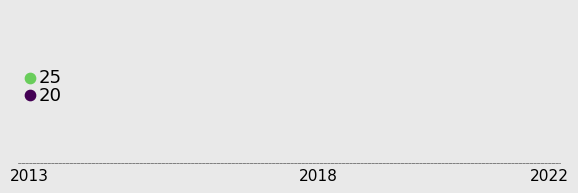

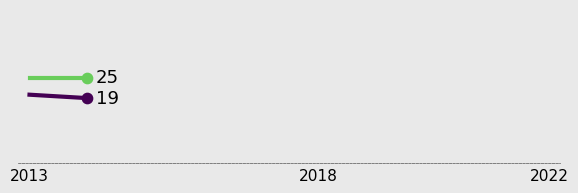

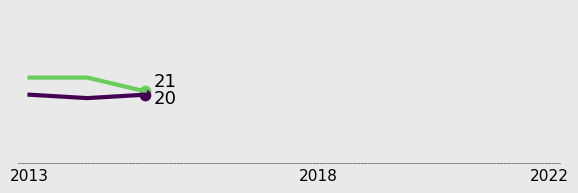

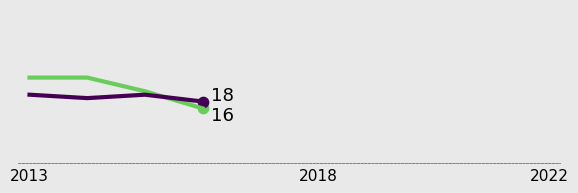

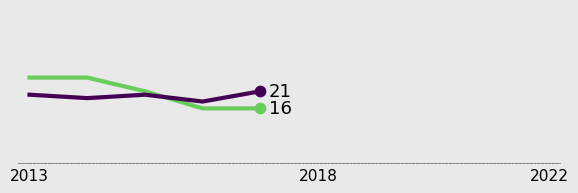

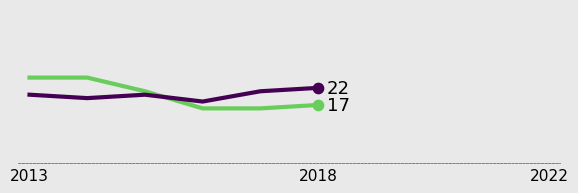

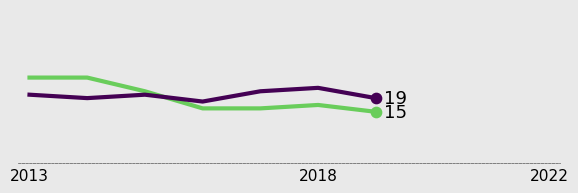

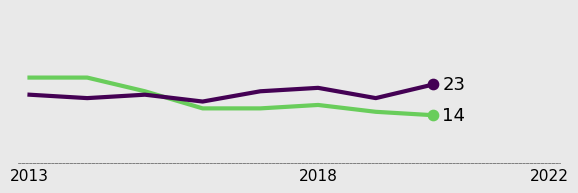

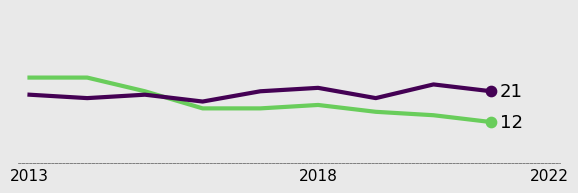

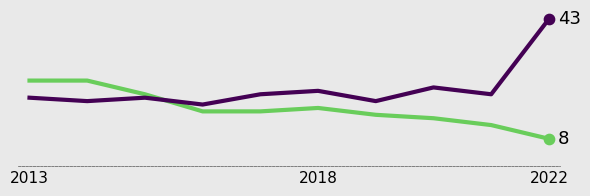

In [179]:
years = [2013,2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]

for year in years:     
    #linechart
    _filter = (gdf["Year (N)"] >= 2013) & (gdf["Year (N)"] <= year) 
    pivot = gdf[_filter].groupby(["Year (N)", "score_class_labels"])["ISO"].count().unstack()
    pivot["Ok"] = pivot[["Good", "Satisfactory"]].sum(axis=1)
    pivot["Bad"] = pivot[["Difficult", "Very serious"]].sum(axis=1)
    
    # 
    fig, ax = plt.subplots(figsize=(7,2))
    fig.patch.set_facecolor("#E9E9E9")
    
    for column in ["Good", "Very serious"]:
        ax.plot(pivot.index, pivot[column], color=colors[column], linewidth=3)
        ax.scatter(pivot.index[-1], pivot[column].iloc[-1], s=55,color=colors[column] )
        
        xpos = 0.15
        ypos = 0      
        if (year == 2015) & (column == "Good"):
            ypos = +3
        if (year == 2015) & (column == "Very serious"):
            ypos = -1
        if (year == 2016) & (column == "Good"):
            ypos = -2
        if (year == 2016) & (column == "Very serious"):
            ypos = +2           
        ax.text(pivot.index[-1]+xpos, pivot[column].iloc[-1]+ypos, pivot[column].iloc[-1], va="center", fontsize=13,
               color="black")
    
    ax.set_ylim(ymin=0, ymax=45)
    ax.yaxis.set_visible(False)
    ax.set_xlim(xmin=2013-0.2, xmax=2022+0.2)
    ax.set_facecolor("#E9E9E9")
    
    for pos in ["top", "right", "left"]:
        ax.spines[pos].set_visible(False)
        
    ax.spines["bottom"].set(color="#555555", linewidth=0.5, linestyle="dashed")
    
    ax.tick_params(size=0, labelsize=11)
    ax.set_xticks([2013,2018,2022])
        
    plt.savefig("linechart_%s.png" %(year), bbox_inches='tight',  transparent=True)